# Sophie

In [26]:
import pandas as pd
import numpy as np

# other
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
from time import time
from pandas.api.types import is_numeric_dtype
from google.colab import drive

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-muted', 'dark_background'])
%matplotlib inline

# processing & model selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# models
try:
    %tensorflow_version 2.x
except Exception:
    pass
  
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Concatenate, Layer, add, GRU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

tf.random.set_seed(410)
np.random.seed(410)

2.0.0


### Player Attributes

# 1. Preprocessing

Due to the complex nature of our dataset, where some of its attributes are temporal and some are not, our model will consist of two separate inputs to account for this. 

In [2]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
df = pd.read_pickle('drive/My Drive/Python/Fut/sofa_dataset.pkl')
df.head(2)

,player_name,overall,club,league,nationality,position,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,date,price,game,days,weekday,promo,source,days_release,relative_price
0,Iniesta,87,other,other,top,CM,171,68,4,69.0,70,68,90.0,79,84,88,94,90,89,70.0,84,70,65,71,74,71,87.0,94,77,70,92,86,80,61.0,66,54,67,57,56,57.0,47,55,58,58,Right,High,Med,4,4,41,2018-09-21,7807,FIFA 19,2,4,0,packs,0.002740,111.00526091283947
1,Iniesta,87,other,other,top,CM,171,68,4,69.0,70,68,90.0,79,84,88,94,90,89,70.0,84,70,65,71,74,71,87.0,94,77,70,92,86,80,61.0,66,54,67,57,56,57.0,47,55,58,58,Right,High,Med,4,4,41,2018-09-22,8714,FIFA 19,3,5,0,packs,0.005479,111.61777891635711


In [4]:
df_train = df[df.game=='FIFA 19']
date_split = datetime(2019, 3, 1)
df_val = df_train[df_train.date>=date_split]
df_train = df_train[df_train.date<date_split]
df_test = df[df.game=='FIFA 20']

print("""{} datapoints in Training Set
{} datapoints in Validation Set
{} datapoints in Test Set"""\
.format(df_train.shape[0], df_val.shape[0], df_test.shape[0]))

81997 datapoints in Training Set
85416 datapoints in Validation Set
6719 datapoints in Test Set


In [0]:
drop_cols = ['player_name', 'resource_id', 'date', 'game', 'relative_price']
temp_cols = ['promo', 'weekday', 'days', 'days_release', 'price']
attr_cols = [c for c in df.columns if c not in (drop_cols + temp_cols)]
target = 'price'

### Temporal Transformation

In [0]:
df_train_temp = df_train.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)
df_val_temp = df_val.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)
df_test_temp = df_test.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)

In [7]:
df_train_temp.head(2)

,date,promo,weekday,days,days_release,price
resource_id,,,,,,
41,2018-09-21,0,4,2,0.002740,7807
41,2018-09-22,0,5,3,0.005479,8714


In [0]:
# temporal variable scaling
temp_num = ['weekday', 'days']
temp_scaler = MinMaxScaler().fit(df_train_temp[temp_num].values)

df_train_temp[temp_num] = temp_scaler.transform(df_train_temp[temp_num].values)
df_val_temp[temp_num] = temp_scaler.transform(df_val_temp[temp_num].values)
df_test_temp[temp_num] = temp_scaler.transform(df_test_temp[temp_num].values)

# price scaling
price_scaler = MinMaxScaler().fit(df_train_temp.price.values.reshape(-1,1))
df_train_temp['price'] = price_scaler.transform(df_train_temp.price.values.reshape(-1,1))
df_val_temp['price'] = price_scaler.transform(df_val_temp.price.values.reshape(-1,1))
df_test_temp['price'] = price_scaler.transform(df_test_temp.price.values.reshape(-1,1))

In [9]:
df_train_temp.head(3)

,date,promo,weekday,days,days_release,price
resource_id,,,,,,
41,2018-09-21,0,0.666667,0.012346,0.002740,0.007430
41,2018-09-22,0,0.833333,0.018519,0.005479,0.008348
41,2018-09-23,0,1.000000,0.024691,0.008219,0.008854


In [0]:
assert df_train_temp.shape[1] == df_test_temp.shape[1] == df_val_temp.shape[1]

### Attributes Transformation

In [0]:
df_train_attr = df_train.groupby('resource_id')[attr_cols].first()
df_val_attr = df_val.groupby('resource_id')[attr_cols].first()
df_test_attr = df_test.groupby('resource_id')[attr_cols].first()

In [0]:
attr_cat = ['club', 'league', 'nationality', 'pref_foot', 'att_workrate', 'def_workrate', 'position', 'source']
attr_num = [v for v in df_train_attr.columns if v not in attr_cat]
num_mask = df_train_attr.columns.isin(attr_num)

ct = make_column_transformer((MinMaxScaler(), num_mask), (OneHotEncoder(), ~num_mask))
attr_ct = ct.fit(df_train_attr)

def attr_transform(df):
    resources = df.index.values
    cols = attr_num + attr_ct.named_transformers_['onehotencoder'].get_feature_names().tolist()
    data = attr_ct.transform(df)
    
    return pd.DataFrame(data=data, columns=cols, index=resources)

df_train_attr = attr_transform(df_train_attr)
df_val_attr = attr_transform(df_val_attr)
df_test_attr = attr_transform(df_test_attr)

In [13]:
df_train_attr.head(3)

,overall,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,weak_foot,skill_moves,x0_other,x0_top,x1_other,x1_top,x2_other,x2_top,x3_CAM,x3_CB,x3_CDM,x3_CF,x3_CM,x3_LB,x3_LF,x3_LM,x3_LW,x3_LWB,x3_RB,x3_RM,x3_RW,x3_RWB,x3_ST,x4_Left,x4_Right,x5_High,x5_Low,x5_Med,x6_High,x6_Low,x6_Med,x7_packs
41,0.4,0.228571,0.219512,0.75,0.540984,0.553846,0.508197,0.888889,0.714286,0.779412,0.702703,0.883721,0.888889,0.68750,0.702703,0.810127,0.681818,0.423729,0.694118,0.731707,0.626667,0.882353,0.947368,0.698630,0.714286,0.825,0.816667,0.763158,0.544118,0.602410,0.338235,0.670588,0.524390,0.5500,0.181818,0.246377,0.043478,0.338710,0.460526,0.666667,0.666667,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
9014,0.2,0.485714,0.512195,0.75,0.704918,0.753846,0.639344,0.844444,0.828571,0.867647,0.621622,0.744186,0.870370,0.56250,0.905405,0.810127,0.852273,0.779661,0.870588,0.878049,0.720000,0.764706,0.802632,0.739726,0.845238,0.575,0.566667,0.894737,0.117647,0.253012,0.294118,0.235294,0.146341,0.1750,0.295455,0.434783,0.239130,0.483871,0.315789,0.000000,0.666667,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
20775,0.1,0.342857,0.195122,0.50,0.770492,0.769231,0.737705,0.844444,0.885714,0.779412,0.432432,0.744186,0.870370,0.40625,0.756757,0.734177,0.647727,0.661017,0.800000,0.804878,0.666667,0.784314,0.815789,0.904110,0.750000,0.500,0.633333,0.947368,0.000000,0.096386,0.147059,0.223529,0.036585,0.0125,0.295455,0.478261,0.260870,0.290323,0.671053,0.666667,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [0]:
assert df_test_attr.shape[1] == df_train_attr.shape[1] == df_val_attr.shape[1]

### Input Processing

In [0]:
def data_process(df_temp, df_attr, num_obs, num_steps):
    """
    Constructs the temporal and attribute datasets for our model
    Arguments:
        - df_temp: our temporal dataframe
        - df_attr: our attributes dataframe
        - num_obs: number of observations to be used in model
        - num_steps: number of steps ahead to predict
    Returns:
        - temp_data: temporal dataset
        - attr_data: attribute dataset
        - targ_data: target dataset
        - reso_data: corresponding resource
    """
    
    resources = df_temp.index.unique().values
    
    reso_data = []
    targ_data = []
    temp_data = []
    attr_data = []
    
    for r in resources:
        
        attributes = df_attr[df_attr.index==r].values[0]
        temporal_d = df_temp[df_temp.index==r].values
        
        total_obs = temporal_d.shape[0]
        window_size = num_obs + num_steps
        
        if window_size > total_obs:
            continue
        
        for i in range(total_obs - window_size):
            
            attr = np.append(attributes, temporal_d[i+num_obs-1][-1])
            temp = temporal_d[i:i+num_obs][:, 1:]
            targ = temporal_d[i+num_obs:i+num_obs+num_steps][:, -1]
            targ_data.append(targ)
            temp_data.append(temp)
            attr_data.append(attr)
            reso_data.append(r)
          
    return np.asarray(attr_data), np.asarray(temp_data), np.asarray(targ_data), np.asarray(reso_data)

In [0]:
train_attr, train_temp, train_targ, train_res = data_process(df_train_temp, df_train_attr, 7, 4)
val_attr, val_temp, val_targ, val_res = data_process(df_val_temp, df_val_attr, 7, 4)
test_attr, test_temp, test_targ, test_res  = data_process(df_test_temp, df_test_attr, 7, 4)

In [0]:
assert train_res.shape[0] == train_temp.shape[0]
assert train_temp.shape[0] == train_targ.shape[0]
assert train_targ.shape[0] == train_attr.shape[0]

# 2. Modeling
The temporal data will be fed into an LSTM layer, the attributes will be fed into a Dense layer; their outputs will be concatenated and fed into more layers. 

In [0]:
train_temp = train_temp.astype(np.float64)
val_temp = val_temp.astype(np.float64)
test_temp = test_temp.astype(np.float64)

train_targ = train_targ.astype(np.float64)
val_targ = val_targ.astype(np.float64)
test_targ = test_targ.astype(np.float64)

In [23]:
print('Temporal shape:', train_temp[0].shape)
print('Attributes shape:', train_attr[0].shape)
print('Target shape:', train_targ[0].shape)

Temporal shape: (7, 5)
Attributes shape: (72,)
Target shape: (4,)


In [0]:
np.random.seed(42)
np.random.shuffle(train_attr)
np.random.seed(42)
np.random.shuffle(train_temp)
np.random.seed(42)
np.random.shuffle(train_targ)

In [0]:
tf.random.set_seed(42)

input_attr = Input(shape=train_attr[0].shape)
input_temp = Input(shape=train_temp[0].shape)

# temporal path
# X_temp1 = GRU(64, activation=None, 
#               recurrent_activation=None,
#               dropout=0.2, recurrent_dropout=0.2,
#               return_sequences=True)(input_temp)
X_temp1 = GRU(64, activation='relu', recurrent_activation='relu',
              dropout=0.2, recurrent_dropout=0.2, 
              return_sequences=True)(input_temp)
X_temp2 = GRU(64, activation='relu', recurrent_activation='relu',
              dropout=0.2, recurrent_dropout=0.2,
              return_sequences=True)(X_temp1)
X_temp3 = GRU(64, activation='relu', recurrent_activation='relu')(X_temp2)

# attribute path
X_attr1 = Dense(64, activation='relu')(input_attr)
X_attr2 = Dense(64, activation='relu')(X_attr1)
X_attr3 = Dense(32, activation='relu')(X_attr2)

# merged path
X = Concatenate(axis=1)([X_attr3, X_temp3])
X = Dense(64, activation='relu')(X)
X = Dense(64, activation='relu')(X)
# X = BatchNormalization()(X)
# output = Dense(train_targ[0].shape[0])(X)
output = Dense(4)(X)

model = Model([input_attr, input_temp], output)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7, 5)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           4672        input_3[0][0]                    
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 7, 64)        13632       input_4[0][0]                    
______________________________________________________________________________________________

In [29]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit([train_attr, train_temp], train_targ,
                    validation_data=([val_attr, val_temp], val_targ),
                    callbacks=callbacks_list,
                    batch_size=32, epochs=10) 

Train on 74007 samples, validate on 73930 samples
Epoch 1/10
74007/74007 [==============================] - 147s 2ms/sample - loss: 0.0010 - val_loss: 3.6615e-04
Epoch 2/10
74007/74007 [==============================] - 141s 2ms/sample - loss: 2.5807e-04 - val_loss: 2.9803e-04
Epoch 3/10
74007/74007 [==============================] - 142s 2ms/sample - loss: 2.2948e-04 - val_loss: 1.8457e-04
Epoch 4/10
74007/74007 [==============================] - 141s 2ms/sample - loss: 2.0798e-04 - val_loss: 2.4234e-04
Epoch 5/10
74007/74007 [==============================] - 141s 2ms/sample - loss: 2.0615e-04 - val_loss: 1.5752e-04
Epoch 6/10
74007/74007 [==============================] - 143s 2ms/sample - loss: 1.9569e-04 - val_loss: 2.3148e-04
Epoch 7/10
74007/74007 [==============================] - 143s 2ms/sample - loss: 1.9202e-04 - val_loss: 1.5695e-04
Epoch 8/10
74007/74007 [==============================] - 142s 2ms/sample - loss: 1.8262e-04 - val_loss: 1.9142e-04
Epoch 9/10
74007/74007 [==

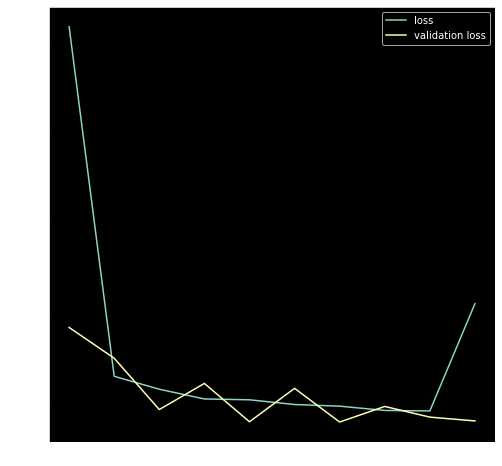

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.legend()
plt.show()

In [0]:
test_preds = model.predict([test_attr, test_temp])

In [32]:
print('Example Target')
example_targ = price_scaler.inverse_transform(test_targ[0]\
                                              .reshape(1, -1))
print(example_targ)
print()


print('Example Prediction')
example_pred = price_scaler.inverse_transform(test_preds[0]\
                                              .reshape(1, -1))
print(example_pred)

Example Target
[[1761. 1747. 1923. 1329.]]

Example Prediction
[[3268.2227 3808.9612 4183.8867 3675.2546]]


# Model Evaluation

Other than the loss metric used above, we can also plot some of the predictions as to get an idea of the model's performance.

In [0]:
def plot_preds(i):
    """
    plot the predictions for ith obs in the test set
    """
    colors = sns.color_palette()

    player_res = test_res[i]
    player_name = df_test[df_test.resource_id == player_res].player_name.values[0]

    i_prices = price_scaler.inverse_transform(test_temp[i][:, -1].reshape(1, -1))
    i_preds = price_scaler.inverse_transform(test_preds[i].reshape(1, -1))[0]
    i_target = price_scaler.inverse_transform(test_targ[i].reshape(1, -1))

    true_prices = np.concatenate([i_prices, i_target], axis=1)[0]
    num_prices = len(true_prices)

    first_d = test_temp[i][:, -2][0] * 365
    x_idx = np.arange(0, num_prices, 1) + first_d

    num_preds = len(i_preds)
    pred_idx = x_idx[-num_preds:]

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(x_idx, true_prices, label='True', color=colors[0])
    ax.plot(pred_idx, i_preds, label='Prediction', color=colors[1])
    ax.set_title(player_name)
    ax.set_xlabel('Days from release')
    ax.legend()

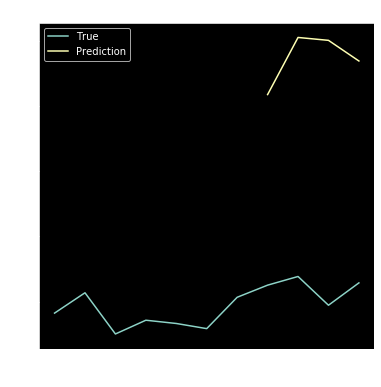

In [37]:
plot_preds(700)

In [0]:
df_test[df_test.resource_id==41].player_name.values[0]

'Andrés Iniesta Luján'

In [0]:
def plot_predictions_resource(i):
    """
    plot the predictions for resource i in the test set
    """
    # get the player's name
    player_name = df_test[df_test.resource_id==i].player_name.values[0]
    is_resource = test_res == i

    i_preds = price_scaler.inverse_transform(test_preds[is_resource].reshape(1, -1))
    i_target = price_scaler.inverse_transform(test_targ[is_resource].reshape(1, -1))

    num_steps = test_targ[0].shape[0]
    extract = [i*num_steps for i in range(100) if i*num_steps < i_target.shape[0]]
    i_preds = np.concatenate(i_preds[extract])
    i_target = np.concatenate(i_target[extract])
    x = np.arange(len(i_preds))

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.plot(x, i_target, label='Actual Price')
    ax.plot(x, i_preds, label='Prediction')
    ax.set_title(player_name)
    ax.legend()

In [0]:
df_test.head(2)

,player_name,overall,club,league,nationality,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,date,price,game,days,weekday,gen_pos,promo,source,days_release,relative_price
167413,Andrés Iniesta Luján,0.83,other,other,top,0.863636,0.68,0.8,0.64,0.64,0.64,0.87,0.79,0.81,0.82,0.91,0.87,0.89,0.7,0.78,0.7,0.67,0.7,0.79,0.71,0.86,0.93,0.77,0.7,0.9,0.84,0.8,0.62,0.66,0.54,0.68,0.59,0.56,0.6,0.43,0.59,0.62,0.58,Right,High,Med,0.8,0.8,41,2019-09-19,2700.0,FIFA 20,0.021918,0.500000,midfielder,0,packs,0.002740,1.0
167414,Andrés Iniesta Luján,0.83,other,other,top,0.863636,0.68,0.8,0.64,0.64,0.64,0.87,0.79,0.81,0.82,0.91,0.87,0.89,0.7,0.78,0.7,0.67,0.7,0.79,0.71,0.86,0.93,0.77,0.7,0.9,0.84,0.8,0.62,0.66,0.54,0.68,0.59,0.56,0.6,0.43,0.59,0.62,0.58,Right,High,Med,0.8,0.8,41,2019-09-20,2700.0,FIFA 20,0.024658,0.666667,midfielder,0,packs,0.005479,1.0


In [0]:
df_test.resource_id.unique()[:10]

array([    41,  41236, 120533, 135507, 138956, 139720, 143076, 152729,
       153079, 155862])

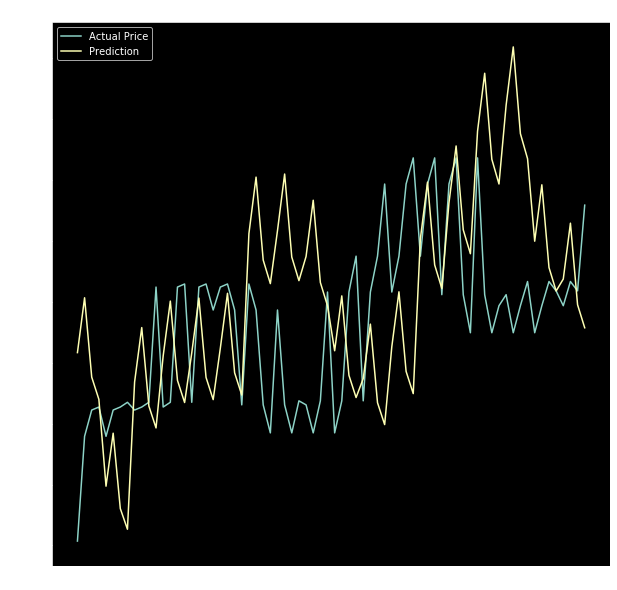

In [0]:
plot_predictions_resource(155862)